# DATA Cleaning 101

## Using simulation to understand the data cleaning cycle

### Simulate messy data 

- We will simulate Intra Cranial Volume (also known as estimated Total Intracranial  Volume (eTIV) in 50k males and females
- In addition, we will simulate CDR for all of these synthetic humans
- This demonstration is only to touch on technical issues that involve data processing so we won't be imposing any effect (i.e. sex, eTIV & CDR)
- What we do is to create datasets with different types of problems
- The goal of this session is to fix the data (and remove rows that cannot be fixed).

### Start by importing basic tools

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')


ModuleNotFoundError: No module named 'seaborn'

### Create a random generator with a seed so we all have the same values

In [1]:
rng = np.random.default_rng(seed = 2022)
n = 50000

### We will start with the CDR values 

#### [CDR® Dementia Staging Instrument](https://knightadrc.wustl.edu/cdr/cdr.htm)

The CDR® Dementia Staging Instrument in one aspect is a 5-point scale used to characterize six domains of cognitive and functional performance applicable to Alzheimer disease and related dementias: Memory, Orientation, Judgment & Problem Solving, Community Affairs, Home & Hobbies, and Personal Care. The necessary information to make each rating is obtained through a semi-structured interview of the patient and a reliable informant or collateral source (e.g., family member) referred to as the CDR® Assessment Protocol.


#### Using the following probabilities, sample five groups 

Seventy-five percent of the population needs to be healthy.  
Probabilities for the rest are smaller.  
Additionally, we want to introduce missing values that represent incomplete observations.  
And add errors and outliers to the code.  

To begin with, here are some sampling probability with matching values

| Value | Probability | CDR context |
| :------------ | :------------ | :---- |
|  0 | 0.75 | Normal |
|  0.5 | 0.05 | Very Mild Dementia |
| 1  | 0.04 | Mild Dementia |
| 2 | 0.04 | Moderate Dementia|
|3 | 0.02 | Severe Dementia |
|np.nan| 0.06 | Missing values|
| `3 ` | 0.015 | error in coding |
| ` ` | 0.015 | error in coding | 
| `99` | 0.01 | Missing values|

In [2]:
p = [0.75,0.05,0.04,0.04,0.02,0.06,0.015,0.015,0.01]
CDR = rng.choice([0,0.5,1,2,3,np.nan,'3 ',' ','99'],replace=True, size=(n,),p=p)

### Introducing a coding error
- We take 20% of severe dementia cases and randomly assign them a value of 30  

In [5]:
ix = np.where(CDR=='3')[0]
rng.shuffle(ix)
CDR[ix[0:int(ix.shape[0]*0.2)]]= 30

### We will do the same with estimated Total Intracranial Volume
- Using the continuous measure of [estimated Total Intracranial Volume](https://surfer.nmr.mgh.harvard.edu/fswiki/eTIV). 
- We start by sampling 50k samples from a normal distribution (using the [numpy.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html) generator) we define our normal distribution cantered around a mean volume of 1.5e6 mm^3 and with 1.8e5 mm^3 width or standard deviation. 
- Then we randomly sample 9% of observations and remove them by replacing their values with `np.nan` using [numpy.random.Generator.integers](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.integers.html).

In [6]:
eTIV = rng.normal(1.5e6,1.8e5,size=(n,))
eTIV[rng.integers(low=0,high=n-1,size=(int(n*0.09),))] = np.nan


### Adding systematic inconsistency
- Making life interesting and introducing another form of error (and some other ways to randomly sample in Python). We are introducing a systematic inconsistency in the data where 32% of observations were coded using cm^3 instead of mm^3

In [38]:
ix = rng.permuted(np.where(~np.isnan(eTIV)))[0,0:int(n*0.32)]
eTIV[ix] = eTIV[ix]*0.001 # tranfrom 32% of the data from mm^3 to cm^3

### Providing sex feature

It is now possible to create a categorical sex variable and introduce different coding errors for this binary value (which are less uncommon than you might think).

In [16]:
p = [0.12,0.4,0.22,0.10,0.10,0.04,0.02]
sex = rng.choice(['M','m ',' F','f','f ',np.nan,' ?'],replace=True, size=(n,),p=p)

### Adding another systematic inconsistency

Keeping with the former systematic inconsistency we introduced, sex values from this site will be numerically coded.

In [8]:
_sex = sex[ix]
for k in np.unique(_sex):
  _k = k.lower().strip()
  v = 1 if _k =='m' else 2 if _k=='f' else 'null'
  _sex[_sex==k] = v
sex[ix] = _sex

#### Or more efficiently using the map function 

In [17]:
sex[ix] = list(map(lambda x: 1 if x=='m' else 2 if x=='f' else 'null', sex[ix]))

#### Finally, we will create a dataframe from this horrific sample


In [85]:
fake_data = pd.DataFrame({'Sex':sex,'eTIV':eTIV,'CDR':CDR})
fake_data.head()

,Sex,eTIV,CDR
0,M,NaN,0
1,F,1.647253e+03,0
2,f,1.329376e+06,0
3,F,1.391975e+03,0
4,m,1.729302e+06,0


### Examining data when you first get it 
- We can use the describe function, but this function treats non-numeric values differently, so it may not be the best choice for examining raw messy data.
- This is a perfect example of how describe() will fail miserably. The reason is not that it isn't useful, but rather that it isn't designed for dealing with datasets  like these.

In [86]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex     50000 non-null  object 
 1   eTIV    45702 non-null  float64
 2   CDR     50000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


### This should raise alarms 
Even if we didn't make this data, I've never seen a raw dataset that was error-free 
The profile of the underlying distributions needs to be examined in any new dataset
Although we can definitely do this with prebuilt functions, making your own will allow you to learn and customize to the specifics of your dataset.

In [87]:
fake_data.describe(include='all').round()

,Sex,eTIV,CDR
count,50000,45702.0,50000
unique,9,NaN,10
top,m,NaN,0
freq,19643,NaN,37540
mean,NaN,976005.0,NaN
std,NaN,729845.0,NaN
min,NaN,716.0,NaN
25%,NaN,1599.0,NaN
50%,NaN,1368160.0,NaN
75%,NaN,1553236.0,NaN


In [53]:
def freq_profile(df:pd.DataFrame) -> pd.DataFrame:
    """freq_profile Create a frequency profile for messy datasets

    Args:
        df (pd.DataFrame): Some raw or tidy data frame

    Returns:
        pd.DataFrame: frequency profile of the input dataset 
    """
    d = []
    columns = df.columns
    for col in columns: 
        if np.issubdtype(df[col].dtype,np.number):
            vc = df[col].value_counts(bins=5).sort_index().reset_index()
            if df[col].isnull().sum()>0:
                vc = vc.append(dict(zip(vc.columns,
                                        [np.nan,df[col].isnull().sum()]))
                               ,ignore_index=True)
        else:
            vc = df[col].value_counts(dropna=False).sort_index().reset_index()
        vc.columns=['Value','Freq']
        vc['Precent']= vc.Freq/df.shape[0]
        vc = pd.concat({col: vc.set_index('Value')},axis=0)
        d.append(vc)
    return pd.concat(d)

In [88]:
profile = freq_profile(fake_data)

## It's now time for everything to be fixed transparently 
It is obvious that this simulates a very problematic dataset. When we encounter something like this in real life, two things are essential: 
- Fix it in a non-destructive manner 
- Explain each step you take 

### Having learned how to fake data now we need to clean it
Fortunately, the eda table clearly identifies some problems (even if you do not possess prior knowledge). As a result, they are easy to fix (in fact, fixing them will be faster than learning how to create them).
A theoretical solution should be evident just by looking at the sex values  
`[ ?, F, 1, 2, M, f, f , m , nan, null]`


### Using regular expressions simplifies this challenge 
Although sometimes these can be automated, from my experience, this is never a good idea.
Instead we will use a powerful tool called regular expressions (press here for a [tutorial on regex](https://learn.datacamp.com/courses/regular-expressions-in-python))
In our example we are using some basic commands 
1. `^.*` search for everything from start to end containing: 
1. `[pattern]` string pattern inside brackets 
1. `[p1|p2|p3]` use `|` to define an `or` operator
2. For example the pattern `^.*[f|F|2]` will search for strings containing 'f' or 'F' or 2 
1. Similarly, in the case of CDR we can use the following expression `^.*[99|nan|\s]` to identify missing results in all there forms 

#### Using this practically 
- We will start with the sex column 
- Using the Sex profile we can see he problem we are facing 

In [46]:
profile.xs('Sex')


,Freq,Precent
Value,,
?,951,0.01902
F,10745,0.21490
2,115,0.00230
M,5962,0.11924
f,4879,0.09758
f,4913,0.09826
m,19643,0.39286
nan,1908,0.03816
null,884,0.01768


### Start with the Sex feature
- We need to define 3 classes mapping
  - Male: '^.*[m|M|1]'
  - Female : '^.*[f|F|2]'
  - Missing : '^.*[null|nan|?]'  

- Putting all of these in a dictionary we can create a mapping device 
- And use replace with regex to remap these values 


In [89]:
cleaned_fake_data = fake_data.copy()
sex_mapper = {'^.*[f|F|2]':'Female', '^.*[m|M|1]':'Male', '^.*[null|nan|?]':np.nan}
cleaned_fake_data.Sex = fake_data.Sex.str.strip().replace(sex_mapper,regex=True)

freq_profile(cleaned_fake_data[['Sex']])

Freq  Precent
    Value                 
Sex Female  20652  0.41304
    Male    25605  0.51210
    NaN      3743  0.07486

### The same approach can be used to remap the CDR data 


In [57]:
profile.xs('CDR')

,Freq,Precent
Value,,
,773,0.01546
0,37540,0.75080
0.5,2545,0.05090
1,1961,0.03922
2,1993,0.03986
3,800,0.01600
3,738,0.01476
30,199,0.00398
99,484,0.00968


In [90]:
CDR_mapper = {'^.*[99|nan|\s]':np.nan, '30':'3'}
cleaned_fake_data.CDR = fake_data.CDR.replace(CDR_mapper,regex=True).astype('str')
freq_profile(cleaned_fake_data[['CDR']])

Freq  Precent
    Value                
CDR 0      37540  0.75080
    0.5     2545  0.05090
    1       1961  0.03922
    2       1993  0.03986
    3        999  0.01998
    nan     4962  0.09924

#### What about continuous data?
- To improve our understanding of continuous features it is useful to use data visualization

In [91]:
profile.xs('eTIV')

,Freq,Precent
Value,,
"(-1514.141, 446819.157]",16000.0,0.32000
"(446819.157, 892921.941]",9.0,0.00018
"(892921.941, 1339024.725]",5440.0,0.10880
"(1339024.725, 1785127.508]",22545.0,0.45090
"(1785127.508, 2231230.292]",1708.0,0.03416
NaN,4298.0,0.08596


<AxesSubplot:xlabel='eTIV', ylabel='Count'>

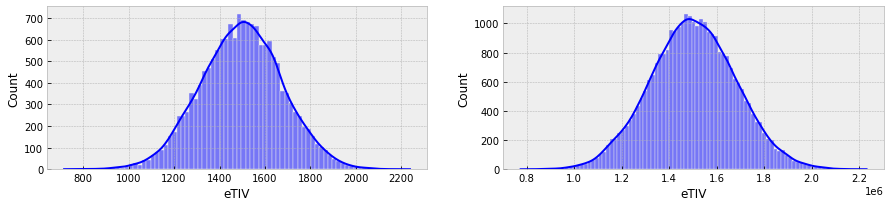

In [98]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
sns.histplot(fake_data.eTIV[fake_data.eTIV<500000],kde=True,ax=ax[0])
sns.histplot(fake_data.eTIV[fake_data.eTIV>0.5e6],kde=True,ax=ax[1])

In [99]:
ix = fake_data.eTIV < 500000
cleaned_fake_data.loc[ix,'eTIV'] = fake_data.eTIV[ix] * 1e3
freq_profile(cleaned_fake_data[['eTIV']])

Freq  Precent
     Value                                       
eTIV (714852.151, 1020702.54]      180.0  0.00360
     (1020702.54, 1325031.285]    7422.0  0.14844
     (1325031.285, 1629360.031]  27384.0  0.54768
     (1629360.031, 1933688.776]  10351.0  0.20702
     (1933688.776, 2238017.521]    365.0  0.00730
     NaN                          4298.0  0.08596

<AxesSubplot:xlabel='eTIV', ylabel='Count'>

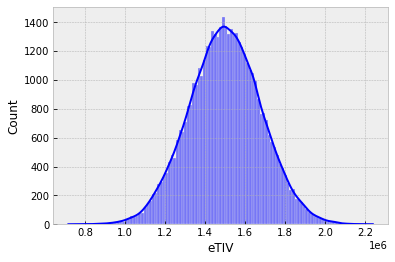

In [101]:
sns.histplot(cleaned_fake_data.eTIV,kde=True)


## Is this valid? 
- Here we created a manual data cleaning process 
- In reality we will check our assumptions with our partners before applying these transformations 